In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

# Analyzing Steel Yield Strengths
In this notebook, we explore the "Mechanical properties of some steels" dataset found on Citrination. The dataset contains 842 entries, with each entry describing one type of steel. This includes the weight percent composition of its 13 constituent elements, as well as several mechanical properties such as yield strength, ultimate tensile strength, and fracture toughness. Here, we examine how the composition of the steel affects its yield strength.

## Loading data

We first download the dataset from https://citrination.com/datasets/153092/show_files as a JSON file, entitling it "steel_data.json". Using Python's JSON library, we convert the JSON file into a list of nested dictionaries.

In [2]:
import json

with open('steel_data.json') as file:
    j = json.load(file)

We want to extract the weight composition of each element, nested under the "composition" key. We also want to extract the yield strength, found under the dictionary key "properties". Let's define this function as "get_properties", which we can then apply over each entry in our dataset.

In [3]:
# get_properties(entry) returns a dictionary with (key, value) pairs as either:
# (element name, weight percent) or (yield stress, value in MPa).
# Requires: (entry) is a dictionary holding the composition and properties
# from the steel data json file.
def get_properties(entry):
    d = {}
    comp = entry['composition'] # List of dictionaries with keys 'element'
                                # and 'actualWeightPercent'
    for e in comp:
        weight = e['actualWeightPercent']
        elem = e['element']
        d.update({elem : weight})

    prop_list = entry['properties']
    for prop in prop_list:
        if prop['name'] == 'Yield strength, YS':
           d.update({'YieldStrength' : prop['scalars']})
           break
    return d

data_dict = list(map(get_properties, j)) # Extract features from each entry in dataset


For easy handling of the data, we can store it in a pandas DataFrame. The dataset contains its values as strings, so we need to convert each number to a float. Next, we write the data to a csv file `steel_data.csv`.

In [4]:
df = pd.DataFrame(data_dict)             
df = df.applymap(lambda x: float(x))
df.to_csv('steel_data.csv', index = False)

print('The features of the data are: ', list(df))

The features of the data are:  ['Al', 'C', 'Co', 'Cr', 'Mn', 'Mo', 'N', 'Nb', 'Ni', 'Si', 'Ti', 'V', 'W', 'YieldStrength']


## Visualizing data using t-SNE

Now that we have our data, let's investigate its structure. We'll use a version of stochastic neighbor embedding called t-SNE to visualize the 13-dimensional compounds in a 2-D plot. Points that are close to each other in high-dimensional space remain close together in the 2-D projection by t-SNE.
<br>

We'll use only the element weight percents of each steel to cluster the points. Then, we'll color the points on the graph based on their yield strengths to see if we have any meaningful clusters.

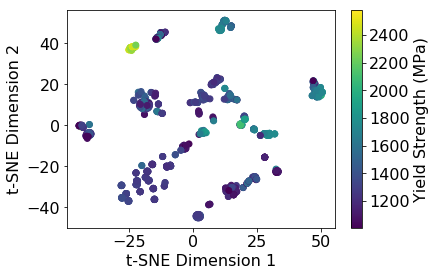

In [5]:
from sklearn.manifold import TSNE

compositions = df.drop('YieldStrength', axis=1).values
yield_strengths = df['YieldStrength'].values

embedding = TSNE(n_components=2, perplexity=25).fit_transform(compositions)
xs = embedding[:,0]
ys = embedding[:,1]

plt.scatter(xs, ys, c=yield_strengths)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Yield Strength (MPa)')
plt.show()


Since t-SNE's loss function is non-convex, minimizing the loss requires a probabilistic approach. This makes the outcome slightly different each time. However, if you rerun t-SNE on this dataset, notice that there is consistently a tight cluster of points with high yield strengths (around 2400 MPa).
<br>

The values of the t-SNE coordinates are only for relative comparison between points; we cannot infer anything from their magnitudes. However, we do know that there is something in the steel composition creating a strong correlation to high yield strength. Let's investigate it further with random forest regression.
<br>

## Random forest regression
The random forest model is useful for finding the features in a dataset that contribute the most to some correlation. They also work well on relatively small datasets (like this one, with less than 1000 points).
<br>

### Training and testing
We'll train a RandomForestRegressor from Scikit-learn to predict yield strengths of steels, given the weight percent compositions of each element. We first split the data into 80% of the samples for training and 20% for testing.


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
         compositions, yield_strengths, test_size=0.2, random_state=42)

Next, let's fit a random forest regressor to our training data. We then predict the yield strengths on our test set, write them to a .csv file, and calculate the R^2 value of prediction.

In [7]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

preds = rfr.predict(X_test) # get predictions for yield strengths
preds = np.around(preds, 3) # round to 3 decimal places
output = np.hstack((X_test,
                    y_test[:,np.newaxis],
                    preds[:,np.newaxis]))

header = list(df) + ['Predicted YS']
df_pred = pd.DataFrame(output, columns=header)
df_pred.to_csv('yield_strength_predictions.csv', index=False)

print('The R^2 coefficient of prediction is: ', rfr.score(X_test, y_test))

The R^2 coefficient of prediction is:  0.793440378784


The R^2 value for the tree's performance hovers around 79%, meaning that approximately 79% of the variance in the yield strength could be explained by the steel's composition. This supports our observations of the clear clustering of high yield strength seen in the t-SNE plot.
<br>

There is still a fair amount of variance that is not captured by the composition. While tuning the composition of steel is an important step in achieving high yield strengths, the processing of the steel also significantly contributes to its performance. The processing steps are not reflected in this dataset, and so we can only draw comparisons with its composition.
<br>

### Feature importances
The trained random forest model gives us the relative importances of each of the features (in this case, weight percent of elements) that led to a correlation with the yield strength. Let's extract these from the model and plot them.

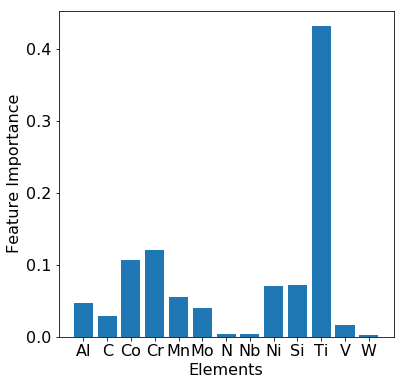

In [8]:
feature_importances = rfr.feature_importances_
feature_names = list(df)[:13]

fig, axes = plt.subplots(figsize=(6,6))
plt.bar(range(len(feature_names)), feature_importances, align='center')
plt.xticks(range(len(feature_names)), feature_names)
plt.xlabel('Elements')
plt.ylabel('Feature Importance')
plt.show()

As you can see, the amount of titanium in the steel had a significantly stronger impact on the yield strength than did the other elements. However, we still don't know the type of correlation it caused: does a high amount of titanium correspond to higher yield strengths, or is it really the other way around?
<br>

We know from materials manufacturing that adding titanium aids the formation of carbides. These carbides promote a finer grained microstructure, leading to higher yield strengths. We check to see if our model supports this by plotting the same t-SNE embedding as before, yet coloring the points by their titanium content instead.

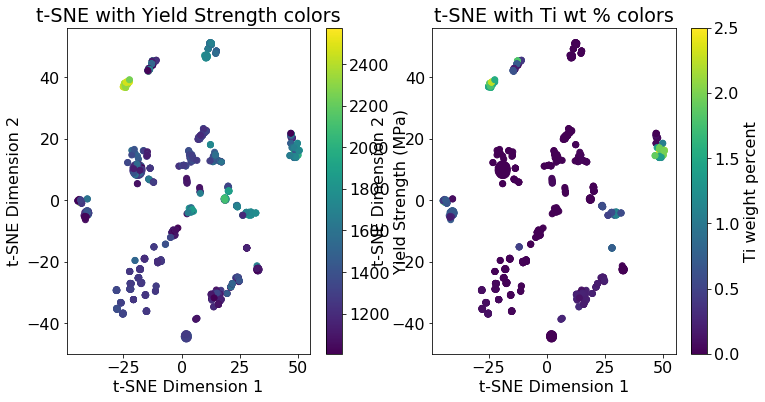

In [9]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

plt.sca(axes[0])
plt.scatter(xs, ys, c=yield_strengths)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Yield Strength (MPa)')
plt.title('t-SNE with Yield Strength colors')

Ti_weights = df['Ti'].values
plt.sca(axes[1])
plt.scatter(xs, ys, c=Ti_weights)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Ti weight percent')
plt.title('t-SNE with Ti wt % colors')

plt.show()

We can see that the cluster with high yield strength also corresponds to a cluster of high titanium content. This supports our model's ability to provide physically meaaningful clusters of data.